In [1]:
import numpy as np
import pandas as pd
import re
import scipy.stats as st
import sklearn.metrics as met
import matplotlib.pyplot as plt
import sklearn.preprocessing as prep
import time

%matplotlib inline
title = "PPD"
path = "C:/Users/recre/OneDrive/Stat"
icy = 'target'

# PPD

## Initiate Data

Read data from orginal data files, save them into database which is easier to reload

### Master Data
Input:
* Training Master Data:
    * PPD_dat_1.csv: First-round training set of Master data
    * PPD_dat_2.csv: First-round validation set of Master data
    * PPD_dat_3.csv: Second-round training set of Master data
    * PPD_dayt_2_1.csv: First-round public validation set of Y Labels
    * PPD_dayt_2_2.csv: First-round private validation set of Y Labels
* Validation Master Data:
    * PPD_dav.csv: Second-round validation set of Master data
    
Output:
* da: master data
* irt, irv: sample indices of training and validation set

In [2]:
def Read_concat_csv(file, par_csv = {}):
    da = pd.concat(map(lambda x: pd.read_csv(x, **par_csv), file))
    return(da)
def Del_string(xstr):
    xstrc = xstr.strip().strip("市").strip("省")
    if(xstrc == ""):
        xstrc = np.nan
    return(xstrc)

### Historical Records Data
Input:
* LogInfo Data:
    * PPD_daht_1_LogInfo.csv: First-round training set of LogInfo data
    * PPD_daht_2_LogInfo.csv: First-round validation set of LogInfo data
    * PPD_daht_3_LogInfo.csv: Second-round training set of LogInfo data
    * PPD_dahv_LogInfo.csv: Second-round validation set of LogInfo data
* UserupdateInfo Data:
    * PPD_daht_1_Userupdate.csv: First-round training set of UserupdateInfo data
    * PPD_daht_2_Userupdate.csv: First-round validation set of UserupdateInfo data
    * PPD_daht_3_Userupdate.csv: Second-round training set of UserupdateInfo data
    * PPD_dahv_LogInfo.csv: Second-round validation set of UserupdateInfo data
    
Output:
* dah1: historical records data: LogInfo
* dah2: historical records data: UserupdateInfo

In [3]:
def Read_History(file, icid, ictime, par_csv = {}):
    '''Organize Time-Dependent Historical Records
    
    Parameters
    ----------
    file: a list of file name
    icid: column name of id
    ictime: a list of 2 column names: [basetime, recordtime]
    par_csv: other parameters for pd.read_csv
    '''
    par = {"parse_dates": ictime}
    par.update(par_csv)
    dah = Read_concat_csv(file, par)
    dahb = (dah.assign(Id = dah[icid], Time = (dah[ictime[1]] - dah[ictime[0]]).astype('timedelta64[D]')).set_index(["Id", "Time"])
            .drop([icid]+ictime, axis = 1).sort_index())
    return(dahb)

## Reload Data
Load data from database, then concatenate and summerize data

In [4]:
da = pd.read_hdf("{}/{}_da.h5".format(path, title), key = "da")
dah1 = pd.read_hdf("{}/{}_dah1.h5".format(path, title), key = "dah")
dah2 = pd.read_hdf("{}/{}_dah2.h5".format(path, title), key = "dah")
irt, irv = np.load("{}/{}_irt.npy".format(path, title)), np.load("{}/{}_irv.npy".format(path, title))

### Concatenate Historical Data with Master Data

In [5]:
def Clean_history(dah, iccat, name):
    grp1 = dah.reset_index()[["Id", "Time"]].groupby("Id")
    grp2 = dah.groupby(level = ["Id", "Time"]).first().reset_index()[["Id", "Time"]].groupby("Id")
    dahc1 = pd.concat([grp1.first(), grp1.count()], axis = 1, ignore_index = True).rename(columns = {0:"FirstTime", 1:"Count"})
    dahc1 = dahc1.assign(DayFreq = grp2.count()["Time"]/(1-dahc1["FirstTime"])).loc[da.index]
    dahc2 = dah.reset_index().groupby(["Id"]+iccat).count().unstack(iccat)["Time"].loc[da.index]
    dahc = pd.concat([dahc1, pd.DataFrame({"Cats": dahc2.notnull().sum(axis = 1)}), dahc2], axis = 1).fillna(0)
    dahc.columns = ["{}_{}".format(name, x) for x in dahc.columns]
    return(dahc)

In [6]:
dah1c = Clean_history(dah1, list(dah1.columns), name = "Log")
dah2c = Clean_history(dah2, list(dah2.columns), name = "Userupdate")
da = pd.concat([da, dah1c, dah2c], axis = 1)
da.shape

(89999, 353)

### Summarize Data
Get univariate summary statistics of data:
* Non-NA values for all variables
* The 5 most frequent values for all variables
* Mean, standard error, and quantiles for numeric variables

In [7]:
def Value_counts(das, nhead = 5):
    tmp = pd.value_counts(das).reset_index().rename_axis({"index": das.name}, axis = 1)
    value = pd.DataFrame(['value {}'.format(x+1) for x in range(nhead)], index = np.arange(nhead)).join(tmp.iloc[:,0], how = "left").set_index(0).T
    freq = pd.DataFrame(['freq {}'.format(x+1) for x in range(nhead)], index = np.arange(nhead)).join(tmp.iloc[:,1], how = "left").set_index(0).T
    nnull = das.isnull().sum()
    freqother = pd.DataFrame({das.name: [das.shape[0]-nnull-np.nansum(freq.values), nnull]}, index = ["freq others", "freq NA"]).T
    op = pd.concat([value, freq, freqother], axis = 1)
    return(op)
def Summary(da):
    op = pd.concat([pd.DataFrame({"type": da.dtypes, "n": da.notnull().sum(axis = 0)}), da.describe().T.iloc[:,1:], 
                    pd.concat(map(lambda i: Value_counts(da.loc[:,i]), da.columns))], axis = 1).loc[da.columns]
    op.index.name = "Columns"
    return(op)

## Clean Data

Input Data: 
* da: master data. types: Numeric, Categorical, Time, or a series of similar columns
* daa*: appendix data for da
    * PPD_daa.csv: additional description of data types
    * cnd_da_city_0.csv: China city rank data
    * cnd_da_city_1.csv: China province/city/county longitudinal/latitudinal data
* ictype: a dict indicating types of and methods for columns of da

Processing:
1. Prepare daa and ictype for transforming da
1. Transforming all of da columns into numeric according to ictype
    * Numeric: Keep
    * Non-numeric: 
        * With additional information: Mapping into numeric
            * Ordinal: As numeric
            * Time: Transform into days and cycles of year, month, week
            * With information in appendix data: Mapping into numeric according to daa*
        * Without additional information: Mapping into 0-1 dummy variables from one-hot encoding, combining or deleting low frequency categories
    * A series of similar columns: Transform the column series into columns of summary statistics, keeping or deleting original columns
    * Count NA numbers in different series of variables
1. Deleting the columns with almost all identical or NA values
1. Deleting the columns with serious collinearity with any column before

Output Data:
* dac: cleaned data. types: numeric


In [8]:
def Col_group(ic, i = 0):
    cols = pd.Series([x.split("_")[i] for x in ic], index = ic)
    return(cols)
daa = pd.read_csv("{}/{}_daa.csv".format(path, title), index_col = "Column")["Type"]
daacity0 = pd.read_csv("{}/cnd_da_city_{}.csv".format(path, 0), encoding = "GB18030", index_col = 0)
daacity1 = pd.read_csv("{}/cnd_da_city_{}.csv".format(path, 1), encoding = "GB18030",
                       converters = {"Prov": Del_string, "City": Del_string, "District": Del_string})
daacity1= (pd.concat(map(lambda i: daacity1.drop_duplicates([i]).set_index([i]).iloc[:,2:], ["Prov", "City", "District"]))
            .reset_index().drop_duplicates(["index"]).set_index(["index"]))
daacity = daacity1.join(daacity0, how = "left")
ictype = {"y": ["target"],
          "date": ["ListingInfo"], 
          "catmap": ["UserInfo_{}".format(i) for i in [2, 4, 8, 20, 7, 19]],
          "catmapd": [daacity]*6,
          }
ictype["cols"] = Col_group(da.drop(ictype["y"], axis = 1).columns)
tmp = ictype["cols"].index[ictype["cols"] == "ThirdParty"]
ictype["serials"] = pd.Series(["_".join([x.split("_")[i] for i in [0,1,3]]) for x in tmp], index = tmp)
ictype["catbin"] = list((set(daa.index[daa == "Categorical"])|set(da.columns[da.dtypes == "O"])) - set(ictype["catmap"]))

In [115]:
def Time_to_num(das):
    tmp = pd.DatetimeIndex(das)
    daop = pd.DataFrame(dict(zip(*[["{}_{}".format(das.name, i) for i in ["Day", "Year", "DayofYear", "DayofMonth", "DayofWeek"]], 
                                   [(das - das.min()).astype('timedelta64[D]').astype(int), tmp.year, tmp.dayofyear, tmp.day, tmp.dayofweek]])),
                        index = das.index)
    return(daop)
def Cat_map(das, damap, fillna = {"CityRank":6}):
    daop = das.reset_index().set_index([das.name]).join(damap, how = "left").set_index(das.index.name).reindex(das.index).fillna(fillna)
    daop.columns = ["{}_{}".format(das.name, i) for i in damap.columns]
    return(daop)
def Cat_to_bin(das, a = 0.01):
    '''Transfrom a categorical column to onehotencoding'''
    tmp = pd.value_counts(das)/das.shape[0]
    cat = list(tmp.index[tmp > a])
    enc = prep.OneHotEncoder(n_values = len(cat)+1, sparse = False)
    xbin = enc.fit_transform(np.transpose(
            [das.astype("category").cat.set_categories(cat).cat.rename_categories(1+np.arange(len(cat))).astype("float").fillna(0).values]))[:,1:]     
    dabin = pd.DataFrame(xbin, columns = ["{}_{}".format(das.name, x) for x in cat], index = das.index)    
    if(tmp[tmp <= a].sum() > a):
        dabin = pd.concat([dabin, pd.DataFrame({"{}_Others".format(das.name):das.notnull()-dabin.sum(axis = 1)})], axis = 1)
    if(dabin.shape[1] == 2):
        dabin = pd.DataFrame({das.name: xbin[:,0]}, index = das.index)
    return(dabin)
def Append_col_name(da, name):
    return(da.rename(columns = dict(zip(*[list(da.columns), ["{}_{}".format(x, name) for x in da.columns]]))))
def ColS_fillna(da, cols, f = "median", allNA = 0):
    dafill = getattr(da[cols.index].groupby(cols, axis = 1), f)()[cols]
    dafill.columns = cols.index
    daop = da[cols.index].fillna(dafill).fillna(allNA)
    return(daop)
def ColS_summary(da, cols, f = ["median", "std"]):
    grp = da[cols.index].groupby(cols, axis = 1)
    daop = pd.concat(map(lambda x: Append_col_name(getattr(grp, x)(), x), f), axis = 1)
    return(daop)
def Clean_data(da, ictype, a = 0.01):
    '''Transform and clean columns according to types'''
    dac = da.copy().replace([-np.inf, np.inf], np.nan).replace("不详", np.nan)
    dac.loc[:, "UserInfo_20"] = dac.loc[:, "UserInfo_20"].fillna(dac.loc[:, "UserInfo_19"])
    datime = pd.concat(map(lambda i: Time_to_num(dac.loc[:,i]), ictype["date"]), axis = 1)
    dacatmap = pd.concat(map(lambda i: Cat_map(dac.loc[:,ictype["catmap"][i]], ictype["catmapd"][i]), range(len(ictype["catmap"]))), axis = 1)
    dacatmap = pd.concat([dacatmap.iloc[:,15:20], ColS_summary(dacatmap, 
        pd.Series(["_".join([x.split("_")[i] for i in [0,2]]) for x in dacatmap.columns[:15]], index = dacatmap.columns[:15]))], axis = 1)
    dacatbin  = pd.concat(map(lambda i: Cat_to_bin(dac.loc[:,i], a = a), ictype["catbin"]+[ictype["catmap"][-1]]), axis = 1)
    daS = ColS_summary(dac, ictype["serials"], ["median", "std", "min", "max", "first"]).fillna(0)
    cols = Col_group(daS.columns, i = -1)
    daS.loc[:,cols == "max"] = daS.loc[:,cols == "max"] - daS.loc[:,cols == "median"].values
    dacount = ColS_summary(dac, ictype["cols"], ["count"])
    dac = pd.concat([dac.drop(ictype["date"] + ictype["catmap"] + ictype["catbin"] + list(ictype["serials"].index), axis = 1), 
                     datime, dacatmap, dacatbin, daS, dacount], axis = 1)
    tmp = pd.concat(map(lambda i: Value_counts(dac.loc[:,i]), dac.columns))
    dac = dac.loc[:, (tmp["freq 1"] + tmp["freq NA"])/dac.shape[0] < 1 - a]
    dac = dac.drop(dac.columns[np.any(np.abs(np.tril(np.corrcoef(dac.rank(pct = True).fillna(0.5).values, rowvar = 0), -1)) > 0.99, axis = 0)], axis = 1)
    return(dac)

In [116]:
dac = Clean_data(da, ictype, a = 0.001)
Summary(dac).to_csv("{}/{}_summary_dac.csv".format(path, title))
dac.shape

(89999, 389)

## Data Sets for Model
### Data Division and Standardization
Divide and standardize X and Y from cleaned data for models

In [131]:
y = dac.loc[:, [icy]]
icx = list(set(dac.columns) - set([icy]))
x = dac.loc[:, icx]
x = x.apply(lambda x: x.fillna(x.median()),axis=0)
x = (x.rank(pct = True)-0.5/x.shape[0]).apply(st.norm.ppf)
#x = (x - x.mean())/x.std()
xv = x.loc[irv].values

### Cross Validation Set
Divide sub training and validation sets by K-folds
* functions for divide and create cross-validation folds
* functions for training/validating models by cross-validation

In [19]:
def Kfolds(x, k = 10, seed = 1):
    np.random.seed(seed)
    xL = np.array_split(np.random.choice(x, len(x), replace = False), k)
    return(xL)
def GroupSelect(xL, i = 0):
    xLc = xL.copy()
    ingrp = list(xLc.pop(i))
    exgrp = sum([list(x) for x in xLc], [])
    return(ingrp, exgrp)
def TrainSet(x, y, irtL, ig = 0):
    irt2, irt1 = GroupSelect(irtL, i = ig)
    xt1, xt2 = x.loc[irt1].values, x.loc[irt2].values
    yt1, yt2 = y.loc[irt1].values, y.loc[irt2].values
    return(xt1, xt2, yt1, yt2)
def CrossTrain(x, y, irtL, fmodel, **kwargs):
    modelL = []
    for i in range(len(irtL)):
        xt1, xt2, yt1, yt2 = TrainSet(x, y, irtL, ig = i)
        modelL.append(fmodel(xt1, xt2, yt1, yt2, seed = i, **kwargs))
    return(modelL)
def CrossValid(x, y, irtL, modelL):
    yt2pL = []
    for i in range(len(irtL)):
        xt1, xt2, yt1, yt2 = TrainSet(x, y, irtL, ig = i)
        yt2p = ModelPredict(xt2, modelL[i])
        yt2pL.append(yt2p)
    return(yt2pL)

In [20]:
irtL = Kfolds(irt, k = 10)

## Model Functions
Functions for models to train, validate and predict Y from data
### Model Evaluation (functions)
Score function and predictor for evaluating machine learning models

In [21]:
def Score(y, yp, f = met.roc_auc_score):
    score = f(y, yp)
    print("Score: {:.4f}".format(score))
    return(score)
def ModelPredict(xv, fmodel):
    if(type(fmodel) == xgb.core.Booster):
        xv = xgb.DMatrix(xv, missing = np.nan)
    if(type(fmodel) in [lm.logistic.LogisticRegression, lm.stochastic_gradient.SGDClassifier, ensm.bagging.BaggingClassifier,
           ensm.weight_boosting.AdaBoostClassifier, ensm.forest.RandomForestClassifier, ensm.forest.ExtraTreesClassifier]):
        yvp = fmodel.predict_proba(xv)[:,1]
    else:
        yvp = fmodel.predict(xv).flatten()
    return(yvp)

### Types of Training Models (functions)
Different model types for training from sub training and validation sets, random seed and model parameters

Input:
* xt1, yt1: sub training sets for data
* xt2, yt2: sub validation sets for data
* seed: random seed for the model
* parmodel: parameters of the model

Processing:
1. Train the model
1. Print validation score and running time

Output:
* model: trained machine learning model

#### Model Type: Scikit-learn Classifiers
Support of modeltype:
* lm: LogisticRegression, SGDClassifier
* ensm: AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

In [22]:
import sklearn.linear_model as lm
import sklearn.ensemble as ensm
def Classifier(xt1, xt2, yt1, yt2, seed = 0, modeltype = lm.LogisticRegression, parmodel = {}):
    timestart = time.time()
    par = {"random_state": seed, 'n_jobs': -1, "penalty": "l2", "C": 0.003, "class_weight": 'balanced', 'solver': 'sag'}
    par.update(parmodel)
    model = modeltype(**par)
    model.fit(xt1, yt1.flatten())
    score = Score(yt2, model.predict_proba(xt2)[:,1:])
    print("Time: {:.2f} seconds".format(time.time() - timestart))
    return(model)

#### Model Type: XGBoost

In [67]:
import xgboost as xgb
def XGBoost(xt1, xt2, yt1, yt2, seed = 0, parmodel = {}):
    timestart = time.time()
    xyt1 = xgb.DMatrix(xt1, label = yt1, missing = np.nan)
    xyt2 = xgb.DMatrix(xt2, label = yt2, missing = np.nan)
    par = {'colsample_bylevel': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'sub_sample': 1, 
           'eta': 0.1, "seed": seed, "objective": 'binary:logistic', 'eval_metric': 'logloss'}
    par.update(parmodel)
    par["max_depth"] = int(par["max_depth"])
    parval = [(xyt1,'train'), (xyt2,'val')]
    model = xgb.train(params = par, dtrain = xyt1, num_boost_round = 10000, evals = parval, 
                      early_stopping_rounds = int(2*np.sqrt(xt1.shape[1]/par["eta"])))
    score = Score(yt2, ModelPredict(xt2, model))
    print("Time: {:.2f} seconds".format(time.time() - timestart))
    return(model)

#### Model Type: Neural Network

In [102]:
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.regularizers import activity_l2
from keras.constraints import maxnorm
def DNN(xt1, xt2, yt1, yt2, seed = 0, parmodel = {}):
    np.random.seed(seed)
    timestart = time.time()
    par = {"nhidlayer": 2, "rdrop": 0.5, "nhidnode": 500, "outnode": 300,
           'optimizer':'sgd', "batch_size": 64, "earlystop": 3, "maxnorm": 4, "l2": 0}
    par.update(parmodel)
    layerin = Input(shape=(xt1.shape[1],))
    layer = layerin
    for i in range(par["nhidlayer"]):
        layer = Dense(par["nhidnode"], init = 'glorot_normal', activation="relu", W_constraint = maxnorm(par["maxnorm"]))(layer)
        layer = BatchNormalization()(layer)
        layer = Dropout(par["rdrop"])(layer)
    layer = Dense(par["outnode"], init = 'glorot_normal', activation="relu", W_constraint = maxnorm(par["maxnorm"]))(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(par["rdrop"])(layer)
    layerout = Dense(1, activation='sigmoid')(layer)
    model = Model(input=layerin, output=layerout)
    model.compile(loss='binary_crossentropy', optimizer=par['optimizer'])
    model.fit(xt1.astype("float32"), yt1.astype("float32"), nb_epoch=100, batch_size=par["batch_size"], validation_data = (xt2, yt2), 
              callbacks = [EarlyStopping(monitor='val_loss', patience=par["earlystop"])])
    score = Score(yt2, ModelPredict(xt2, model))
    print("Time: {:.2f} seconds".format(time.time() - timestart))
    return(model)

### Model Variable Selection (functions)
Importance of variables for models in Y prediction from model training

In [25]:
def PlotWeight(w, score, hl = 0):
    fig = plt.figure()
    w.plot(kind = "bar", grid = True, title = "Score = {:.4}".format(score))
    plt.plot((0, w.shape[0]), (hl, hl), "k-")   
    fig.show()
def WeightModel(model):
    if(type(model) == lm.logistic.LogisticRegression):
        wic = pd.DataFrame({"LR_beta":model.coef_[0]}, index = x.columns)
    elif(type(model) == xgb.core.Booster):
        wic = (pd.concat([pd.Series(icx, index = ['f{}'.format(x) for x in range(len(icx))]), pd.Series(model.get_fscore())], axis = 1)
               .set_index(0).sort_index().fillna(0)[1])
        wic = wic/np.sum(wic)*wic.shape[0]
    return(wic)
def WeightCI(fweight, modelL):
    w = pd.concat(map(fweight, modelL), axis = 1, keys = np.arange(len(modelL)))
    wb = pd.concat([w.mean(axis = 1), w.std(axis = 1)], axis = 1, keys = ["Mean", "Std"])
    wb["LowerCI"] = wb["Mean"] - wb["Std"]*1.96/np.sqrt(len(modelL))
    wb["UpperCI"] = wb["Mean"] + wb["Std"]*1.96/np.sqrt(len(modelL))
    return(wb)

### Model Comparasion and Composite (functions)
Compare one/multiple models with cross validation and weighted average
* functions for evaluate weights of models according to cross-validation scores for weighted-average prediction
* functions for using weights for models to predict

In [26]:
def ScoreWeight(score):
    w = np.exp((score - np.mean(score))/np.min(np.std(score, axis = 0)))
    w = np.sum(w/np.sum(w), axis = 0)
    return(w)
def CrossScore(y, yt2pM, irtL, w = 1):
    score = []
    for i in range(len(irtL)):
        xt1, xt2, yt1, yt2 = TrainSet(y, y, irtL, ig = i)
        yt2L = [yt2pM[j][i] for j in range(len(yt2pM))]
        if(w is 1):
            score.append(list(map(lambda x: Score(yt2, x), yt2L)))
        else:
            score.append(Score(yt2, np.array(yt2L).T @ w))
    return(np.array(score))
def CrossScoreAnalysis(y, yt2pM, irtL, w = [], labels = None):
    scoreL = CrossScore(y, yt2pM, irtL)
    if(len(w) == 0):    
        w = ScoreWeight(scoreL)
    score = CrossScore(y, yt2pM, irtL, w)
    ScorePlot(np.vstack([score, scoreL.T]).T, labels)
    return(scoreL, score, np.array(w))
def ScorePlot(scoreL, labels):
    scmean, scmstd = np.mean(scoreL[:,0]), np.std(scoreL[:,0])/np.sqrt(scoreL.shape[0])
    plt.figure()
    plt.boxplot(scoreL, labels = labels, showmeans = True)
    plt.plot((0, scoreL.shape[1]+1), (scmean, scmean), "g-")
    plt.plot((0, scoreL.shape[1]+1), (scmean - 1.96*scmstd, scmean - 1.96*scmstd), "g--") 
    plt.plot((0, scoreL.shape[1]+1), (scmean + 1.96*scmstd, scmean + 1.96*scmstd), "g--") 
    plt.title("Comp Mean Score: {:.4f},  95% CI: ({:.4f}, {:.4f}),  Folds: {}".format(scmean, scmean - 1.96*scmstd, scmean + 1.96*scmstd, scoreL.shape[0]))
    plt.grid()
    plt.show()
def CrossPredict(xv, modelL):
    yvpL = []
    for i in range(len(modelL)):
        yvp = ModelPredict(xv, modelL[i])
        yvpL.append(yvp)
    return(yvpL)
def ModelMPredict(yvpM, w = 1):
    yvpcomp = np.array([np.mean(yvpM[i], axis = 0) for i in range(len(yvpM))]).T.dot(w).flatten()
    return(yvpcomp)

## Model Pre-Training
Training for model selection and preestimate of hyper-parameters
### Single Models
Train a single model from a single pair of sub training and validation sets

In [118]:
xt1, xt2, yt1, yt2 = TrainSet(x, y, irtL, ig = 0)

In [78]:
model = Classifier(xt1, xt2, yt1, yt2, seed = 0, modeltype = lm.LogisticRegression, parmodel = 
                   {"penalty": "l2", "C": 0.003, "class_weight": 'balanced', 'solver': 'sag'})

Score: 0.7761
Time: 6.79 seconds


In [23]:
model = XGBoost(xt1, xt2, yt1, yt2, seed = 0, parmodel = 
                {'colsample_bylevel': 0.07, 'eta': 0.05, 'max_depth': 3, 'lambda': 50, 'min_child_weight': 1.5, 'gamma': 0.2})

Score: 0.7850
Time: 143.23 seconds


In [96]:
model = DNN(xt1, xt2, yt1, yt2, seed = 0, parmodel = 
            {"nhidlayer": 1, "rdrop": 0.5, "nhidnode": 500, 'optimizer': "rmsprop", "batch_size": 64, "dropout": 0.5})

Train on 71999 samples, validate on 8000 samples
Epoch 1/100
71999/71999 [==============================] - 24s - loss: 0.3049 - val_loss: 0.2434
Epoch 2/100
71999/71999 [==============================] - 29s - loss: 0.2426 - val_loss: 0.2387
Epoch 3/100
71999/71999 [==============================] - 31s - loss: 0.2365 - val_loss: 0.2384
Epoch 4/100
71999/71999 [==============================] - 30s - loss: 0.2332 - val_loss: 0.2385
Epoch 5/100
71999/71999 [==============================] - 30s - loss: 0.2312 - val_loss: 0.2373
Epoch 6/100
71999/71999 [==============================] - 30s - loss: 0.2280 - val_loss: 0.2431
Epoch 7/100
71999/71999 [==============================] - 28s - loss: 0.2276 - val_loss: 0.2369
Epoch 8/100
71999/71999 [==============================] - 27s - loss: 0.2254 - val_loss: 0.2367
Epoch 9/100
71999/71999 [==============================] - 25s - loss: 0.2251 - val_loss: 0.2398
Epoch 10/100
71999/71999 [==============================] - 30s - loss: 0.2237

In [45]:
model = Classifier(xt1, xt2, yt1, yt2, seed = 0, modeltype = ensm.BaggingClassifier, parmodel = 
                   {"base_estimator":ensm.ExtraTreesClassifier(criterion='entropy', min_weight_fraction_leaf=0, max_depth = 6),
                   "n_estimators": 500, "max_features": 1})

Score: 0.6995
Time: 294.38 seconds


## Model Hyper-parameters Optimization
Hyper-parameters optimization for models with cross validaion

Warning: The process of hyper-parameters optimization may take a very long time = N(iterations)\*K(folds)\*T(single model)

In [111]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic
def ParColScore(par, fmodel = XGBoost):
    icx = list(wcol.index[wcol.iloc[:,1] > par["a"]])
    x = dac.loc[:, icx]
    x = x.apply(lambda x: x.fillna(x.median()),axis=0)
    x = (x.rank(pct = True)-0.5/x.shape[0]).apply(st.norm.ppf)
    modelL = CrossTrain(x, y, irtL, fmodel)
    yt2pL = CrossValid(x, y, irtL, modelL)
    score = np.mean(CrossScoreAnalysis(y, [yt2pL], irtL)[0])
    return(-score)
def ParModelScore(par, fmodel = XGBoost):
    irtL = Kfolds(irt, k = 5)
    modelL = CrossTrain(x, y, irtL, fmodel, parmodel = par)
    yt2pL = CrossValid(x, y, irtL, modelL)
    score = np.mean(CrossScoreAnalysis(y, [yt2pL], irtL)[0])
    return(-score)
def HpOpt(space, fhpscore, seed = 0, max_evals = 50):
    def Obj(par):
        print(pd.DataFrame(par, index = [seed]))
        return({
            'loss': fhpscore(par),
            'status': STATUS_OK,
            'loss_variance': 5e-5
            })
    np.random.seed(seed)
    trials = Trials()
    best = fmin(Obj,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials)
    op = pd.concat([pd.DataFrame([sum(list(trials.trials[i]["misc"]["vals"].values()), []) for i in range(len(trials))],
                                 columns = list(trials.trials[0]["misc"]["vals"].keys())),
           pd.DataFrame({"loss": trials.losses()})], axis = 1)
    return(op)

In [44]:
space = {'C': hp.loguniform("C", -10, -2)}
print(hyperopt.pyll.stochastic.sample(space))

{'C': 9.283853539473838e-05}


In [ ]:
parda = HpOpt(space, lambda x:ParModelScore(x, fmodel = Classifier), max_evals = 30).sort_values(["loss"])
parda.to_csv("{}/{}_par_lgr.csv".format(path, title))
paropt = parda.iloc[0, :-1].to_dict()
parda

In [70]:
space = {'max_depth': hp.quniform("max_depth", 1.5, 4.5, 1),
         'min_child_weight': hp.loguniform("min_child_weight", -2, 4),
         'gamma': hp.loguniform("gamma", -6, 2),
         'lambda': hp.loguniform("lambda", 0, 6),
         'colsample_bylevel': hp.uniform('colsample_bylevel', 0.04, 0.15)
}
print(hyperopt.pyll.stochastic.sample(space))

{'gamma': 0.2434874734418997, 'min_child_weight': 16.245731608503576, 'max_depth': 4.0, 'lambda': 10.653284672394888, 'colsample_bylevel': 0.07780665788770644}


   colsample_bylevel     gamma    lambda  max_depth  min_child_weight
0           0.103231  0.107672  1.758499        4.0         34.273935
Score: 0.7864
Time: 63.60 seconds
Score: 0.7957
Time: 70.17 seconds
Score: 0.7727
Time: 47.90 seconds
Score: 0.7791
Time: 53.02 seconds
Score: 0.7689
Time: 45.33 seconds
Score: 0.7864
Score: 0.7957
Score: 0.7727
Score: 0.7791
Score: 0.7689
Score: 0.7864
Score: 0.7957
Score: 0.7727
Score: 0.7791
Score: 0.7689


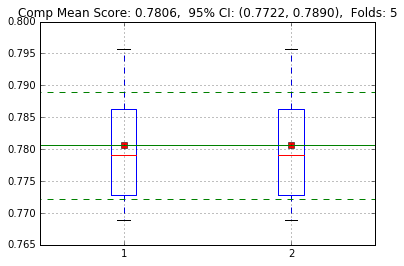

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0            0.05411  0.002601  394.391123        2.0          37.29148
Score: 0.7875
Time: 159.03 seconds
Score: 0.8023
Time: 197.84 seconds
Score: 0.7735
Time: 165.98 seconds
Score: 0.7803
Time: 160.58 seconds
Score: 0.7679
Time: 155.20 seconds
Score: 0.7875
Score: 0.8023
Score: 0.7735
Score: 0.7803
Score: 0.7679
Score: 0.7875
Score: 0.8023
Score: 0.7735
Score: 0.7803
Score: 0.7679


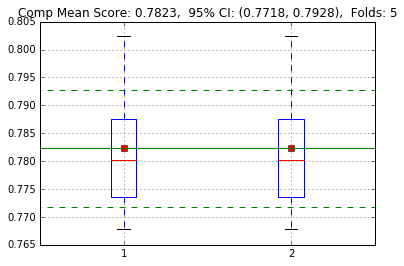

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0              0.108  0.103667  75.388268        4.0          0.983615
Score: 0.7873
Time: 78.25 seconds
Score: 0.7978
Time: 93.50 seconds
Score: 0.7727
Time: 68.59 seconds
Score: 0.7787
Time: 73.84 seconds
Score: 0.7694
Time: 56.74 seconds
Score: 0.7873
Score: 0.7978
Score: 0.7727
Score: 0.7787
Score: 0.7694
Score: 0.7873
Score: 0.7978
Score: 0.7727
Score: 0.7787
Score: 0.7694


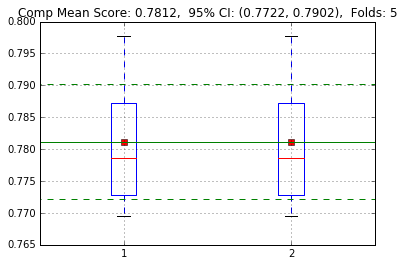

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0           0.062041  2.815963  119.438209        4.0          0.320332
Score: 0.7858
Time: 94.08 seconds
Score: 0.8012
Time: 80.70 seconds
Score: 0.7759
Time: 71.71 seconds
Score: 0.7810
Time: 93.83 seconds
Score: 0.7707
Time: 93.64 seconds
Score: 0.7858
Score: 0.8012
Score: 0.7759
Score: 0.7810
Score: 0.7707
Score: 0.7858
Score: 0.8012
Score: 0.7759
Score: 0.7810
Score: 0.7707


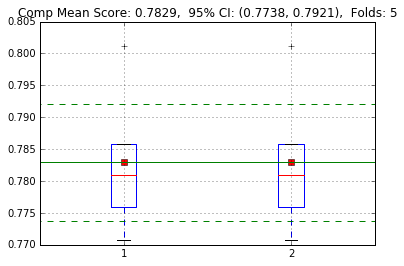

   colsample_bylevel     gamma    lambda  max_depth  min_child_weight
0           0.103638  0.005734  9.649955        4.0          6.631517
Score: 0.7829
Time: 75.80 seconds
Score: 0.7964
Time: 90.46 seconds
Score: 0.7720
Time: 53.17 seconds
Score: 0.7782
Time: 62.85 seconds
Score: 0.7707
Time: 48.23 seconds
Score: 0.7829
Score: 0.7964
Score: 0.7720
Score: 0.7782
Score: 0.7707
Score: 0.7829
Score: 0.7964
Score: 0.7720
Score: 0.7782
Score: 0.7707


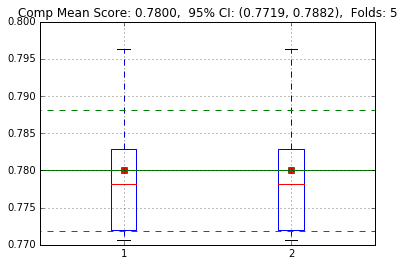

   colsample_bylevel     gamma    lambda  max_depth  min_child_weight
0           0.103523  0.003093  6.275718        4.0          8.628248
Score: 0.7847
Time: 75.67 seconds
Score: 0.7987
Time: 58.73 seconds
Score: 0.7713
Time: 53.58 seconds
Score: 0.7779
Time: 54.63 seconds
Score: 0.7664
Time: 54.16 seconds
Score: 0.7847
Score: 0.7987
Score: 0.7713
Score: 0.7779
Score: 0.7664
Score: 0.7847
Score: 0.7987
Score: 0.7713
Score: 0.7779
Score: 0.7664


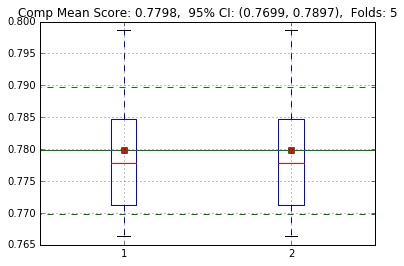

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.121014  0.008721  27.970595        4.0          4.887325
Score: 0.7877
Time: 84.71 seconds
Score: 0.7996
Time: 81.38 seconds
Score: 0.7762
Time: 64.85 seconds
Score: 0.7793
Time: 80.12 seconds
Score: 0.7694
Time: 58.04 seconds
Score: 0.7877
Score: 0.7996
Score: 0.7762
Score: 0.7793
Score: 0.7694
Score: 0.7877
Score: 0.7996
Score: 0.7762
Score: 0.7793
Score: 0.7694


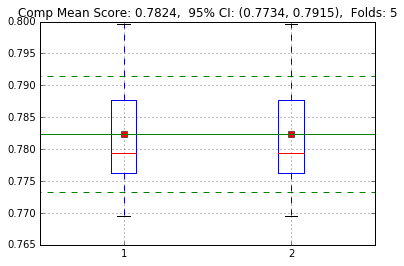

   colsample_bylevel    gamma    lambda  max_depth  min_child_weight
0           0.086997  0.12068  3.170096        3.0          3.656034
Score: 0.7858
Time: 76.91 seconds
Score: 0.8007
Time: 87.11 seconds
Score: 0.7717
Time: 49.78 seconds
Score: 0.7789
Time: 76.20 seconds
Score: 0.7695
Time: 53.17 seconds
Score: 0.7858
Score: 0.8007
Score: 0.7717
Score: 0.7789
Score: 0.7695
Score: 0.7858
Score: 0.8007
Score: 0.7717
Score: 0.7789
Score: 0.7695


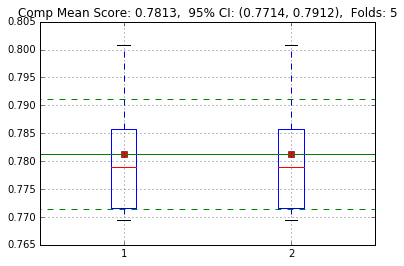

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.136027  1.481315  27.053301        4.0          0.652312
Score: 0.7862
Time: 91.25 seconds
Score: 0.8006
Time: 84.82 seconds
Score: 0.7748
Time: 70.28 seconds
Score: 0.7795
Time: 71.60 seconds
Score: 0.7717
Time: 65.75 seconds
Score: 0.7862
Score: 0.8006
Score: 0.7748
Score: 0.7795
Score: 0.7717
Score: 0.7862
Score: 0.8006
Score: 0.7748
Score: 0.7795
Score: 0.7717


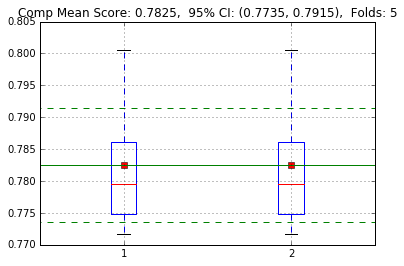

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.059903  2.676418  284.85398        2.0          0.176539
Score: 0.7837
Time: 283.56 seconds
Score: 0.7956
Time: 167.38 seconds
Score: 0.7716
Time: 162.88 seconds
Score: 0.7780
Time: 157.65 seconds
Score: 0.7640
Time: 170.45 seconds
Score: 0.7837
Score: 0.7956
Score: 0.7716
Score: 0.7780
Score: 0.7640
Score: 0.7837
Score: 0.7956
Score: 0.7716
Score: 0.7780
Score: 0.7640


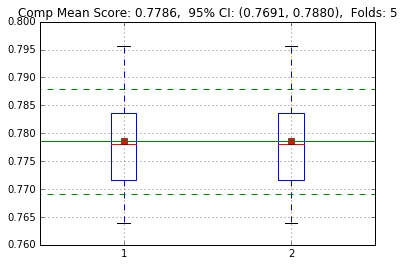

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.122874  0.782896  53.059224        3.0           0.80767
Score: 0.7882
Time: 99.21 seconds
Score: 0.8012
Time: 130.87 seconds
Score: 0.7749
Time: 75.28 seconds
Score: 0.7813
Time: 91.13 seconds
Score: 0.7700
Time: 68.41 seconds
Score: 0.7882
Score: 0.8012
Score: 0.7749
Score: 0.7813
Score: 0.7700
Score: 0.7882
Score: 0.8012
Score: 0.7749
Score: 0.7813
Score: 0.7700


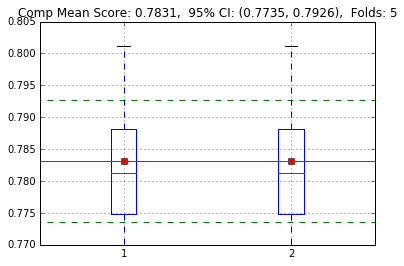

   colsample_bylevel    gamma      lambda  max_depth  min_child_weight
0             0.0584  6.55951  116.272894        4.0         19.999858
Score: 0.7861
Time: 184.56 seconds
Score: 0.7979
Time: 179.26 seconds
Score: 0.7752
Time: 154.27 seconds
Score: 0.7792
Time: 142.88 seconds
Score: 0.7665
Time: 114.21 seconds
Score: 0.7861
Score: 0.7979
Score: 0.7752
Score: 0.7792
Score: 0.7665
Score: 0.7861
Score: 0.7979
Score: 0.7752
Score: 0.7792
Score: 0.7665


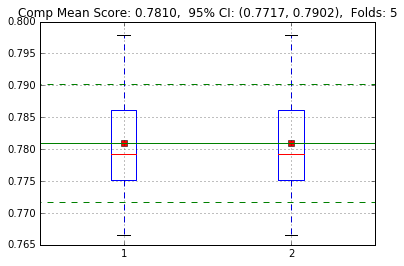

   colsample_bylevel     gamma    lambda  max_depth  min_child_weight
0            0.11273  1.196045  2.400008        4.0         16.976268
Score: 0.7830
Time: 59.06 seconds
Score: 0.7969
Time: 98.08 seconds
Score: 0.7745
Time: 49.36 seconds
Score: 0.7782
Time: 59.23 seconds
Score: 0.7675
Time: 40.04 seconds
Score: 0.7830
Score: 0.7969
Score: 0.7745
Score: 0.7782
Score: 0.7675
Score: 0.7830
Score: 0.7969
Score: 0.7745
Score: 0.7782
Score: 0.7675


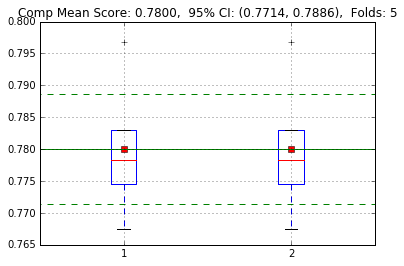

   colsample_bylevel     gamma    lambda  max_depth  min_child_weight
0           0.055573  2.954674  1.654055        2.0         18.316502
Score: 0.7860
Time: 161.80 seconds
Score: 0.7999
Time: 139.83 seconds
Score: 0.7722
Time: 66.62 seconds
Score: 0.7787
Time: 96.65 seconds
Score: 0.7690
Time: 88.52 seconds
Score: 0.7860
Score: 0.7999
Score: 0.7722
Score: 0.7787
Score: 0.7690
Score: 0.7860
Score: 0.7999
Score: 0.7722
Score: 0.7787
Score: 0.7690


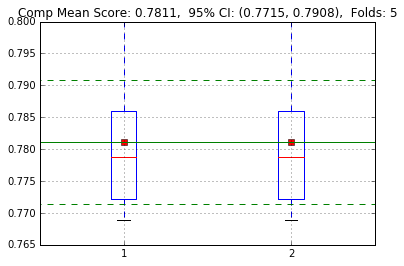

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0           0.072342  0.025001  152.850175        4.0         25.730014
Score: 0.7895
Time: 120.33 seconds
Score: 0.8032
Time: 117.20 seconds
Score: 0.7743
Time: 85.28 seconds
Score: 0.7809
Time: 84.19 seconds
Score: 0.7704
Time: 80.84 seconds
Score: 0.7895
Score: 0.8032
Score: 0.7743
Score: 0.7809
Score: 0.7704
Score: 0.7895
Score: 0.8032
Score: 0.7743
Score: 0.7809
Score: 0.7704


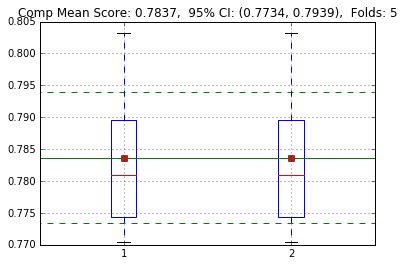

   colsample_bylevel    gamma    lambda  max_depth  min_child_weight
0           0.053388  0.00616  3.133251        4.0          2.015256
Score: 0.7830
Time: 51.77 seconds
Score: 0.8001
Time: 83.49 seconds
Score: 0.7695
Time: 48.55 seconds
Score: 0.7812
Time: 74.30 seconds
Score: 0.7687
Time: 53.59 seconds
Score: 0.7830
Score: 0.8001
Score: 0.7695
Score: 0.7812
Score: 0.7687
Score: 0.7830
Score: 0.8001
Score: 0.7695
Score: 0.7812
Score: 0.7687


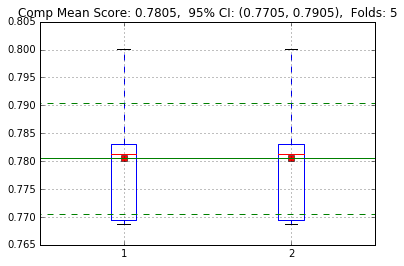

   colsample_bylevel     gamma    lambda  max_depth  min_child_weight
0           0.117038  0.007919  7.421553        4.0          4.159425
Score: 0.7841
Time: 75.52 seconds
Score: 0.8000
Time: 77.83 seconds
Score: 0.7721
Time: 56.68 seconds
Score: 0.7797
Time: 61.42 seconds
Score: 0.7691
Time: 68.25 seconds
Score: 0.7841
Score: 0.8000
Score: 0.7721
Score: 0.7797
Score: 0.7691
Score: 0.7841
Score: 0.8000
Score: 0.7721
Score: 0.7797
Score: 0.7691


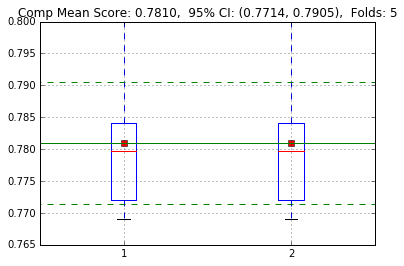

   colsample_bylevel     gamma    lambda  max_depth  min_child_weight
0           0.126068  0.014513  1.223254        4.0          0.149984
Score: 0.7841
Time: 66.29 seconds
Score: 0.7977
Time: 59.25 seconds
Score: 0.7697
Time: 44.77 seconds
Score: 0.7729
Time: 55.64 seconds
Score: 0.7673
Time: 52.14 seconds
Score: 0.7841
Score: 0.7977
Score: 0.7697
Score: 0.7729
Score: 0.7673
Score: 0.7841
Score: 0.7977
Score: 0.7697
Score: 0.7729
Score: 0.7673


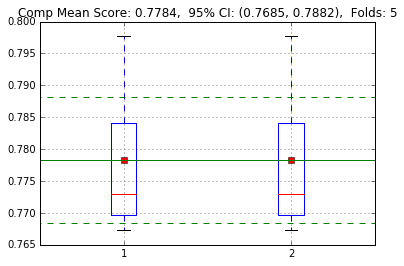

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.066398  6.441836  64.979154        3.0         24.571331
Score: 0.7832
Time: 86.72 seconds
Score: 0.7966
Time: 135.13 seconds
Score: 0.7741
Time: 121.37 seconds
Score: 0.7794
Time: 169.59 seconds
Score: 0.7665
Time: 127.90 seconds
Score: 0.7832
Score: 0.7966
Score: 0.7741
Score: 0.7794
Score: 0.7665
Score: 0.7832
Score: 0.7966
Score: 0.7741
Score: 0.7794
Score: 0.7665


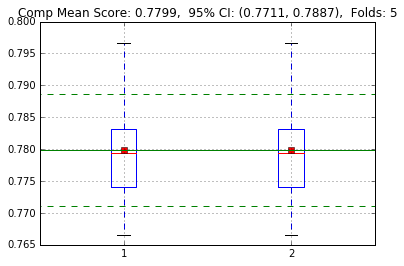

   colsample_bylevel     gamma    lambda  max_depth  min_child_weight
0           0.059174  2.841783  2.733476        4.0          0.351166
Score: 0.7835
Time: 43.56 seconds
Score: 0.7960
Time: 67.81 seconds
Score: 0.7706
Time: 42.35 seconds
Score: 0.7779
Time: 44.66 seconds
Score: 0.7685
Time: 38.65 seconds
Score: 0.7835
Score: 0.7960
Score: 0.7706
Score: 0.7779
Score: 0.7685
Score: 0.7835
Score: 0.7960
Score: 0.7706
Score: 0.7779
Score: 0.7685


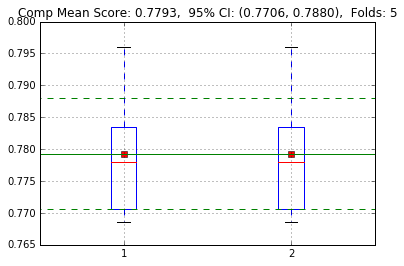

   colsample_bylevel    gamma      lambda  max_depth  min_child_weight
0           0.081782  0.37786  218.150352        3.0          2.177725
Score: 0.7859
Time: 110.83 seconds
Score: 0.8024
Time: 130.54 seconds
Score: 0.7762
Time: 81.85 seconds
Score: 0.7799
Time: 89.65 seconds
Score: 0.7693
Time: 83.10 seconds
Score: 0.7859
Score: 0.8024
Score: 0.7762
Score: 0.7799
Score: 0.7693
Score: 0.7859
Score: 0.8024
Score: 0.7762
Score: 0.7799
Score: 0.7693


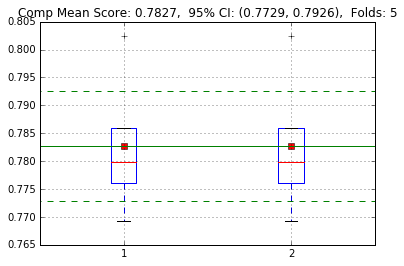

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.146283  0.023728  46.961479        3.0          1.055752
Score: 0.7871
Time: 102.65 seconds
Score: 0.8003
Time: 105.85 seconds
Score: 0.7744
Time: 65.03 seconds
Score: 0.7811
Time: 92.79 seconds
Score: 0.7721
Time: 65.11 seconds
Score: 0.7871
Score: 0.8003
Score: 0.7744
Score: 0.7811
Score: 0.7721
Score: 0.7871
Score: 0.8003
Score: 0.7744
Score: 0.7811
Score: 0.7721


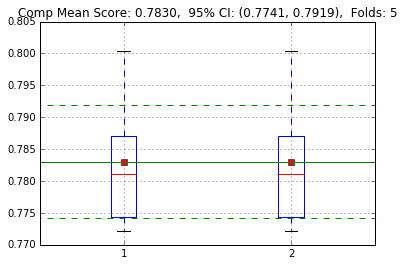

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.042415  0.041511  15.241821        3.0         11.243902
Score: 0.7865
Time: 59.91 seconds
Score: 0.8009
Time: 72.29 seconds
Score: 0.7712
Time: 44.01 seconds
Score: 0.7810
Time: 64.87 seconds
Score: 0.7716
Time: 57.21 seconds
Score: 0.7865
Score: 0.8009
Score: 0.7712
Score: 0.7810
Score: 0.7716
Score: 0.7865
Score: 0.8009
Score: 0.7712
Score: 0.7810
Score: 0.7716


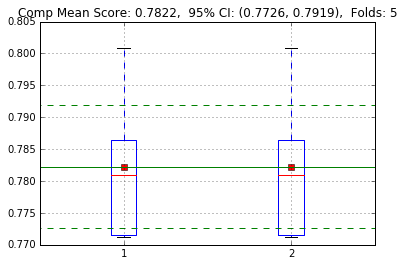

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0            0.07396  0.478429  178.601985        2.0          1.262995
Score: 0.7888
Time: 151.37 seconds
Score: 0.8035
Time: 169.20 seconds
Score: 0.7728
Time: 81.98 seconds
Score: 0.7805
Time: 108.24 seconds
Score: 0.7678
Time: 98.21 seconds
Score: 0.7888
Score: 0.8035
Score: 0.7728
Score: 0.7805
Score: 0.7678
Score: 0.7888
Score: 0.8035
Score: 0.7728
Score: 0.7805
Score: 0.7678


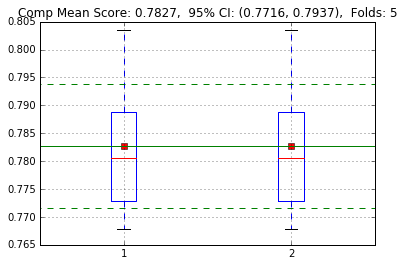

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.090157  0.292144  45.546531        3.0          0.517258
Score: 0.7875
Time: 92.46 seconds
Score: 0.8022
Time: 93.64 seconds
Score: 0.7746
Time: 75.91 seconds
Score: 0.7807
Time: 79.61 seconds
Score: 0.7714
Time: 56.56 seconds
Score: 0.7875
Score: 0.8022
Score: 0.7746
Score: 0.7807
Score: 0.7714
Score: 0.7875
Score: 0.8022
Score: 0.7746
Score: 0.7807
Score: 0.7714


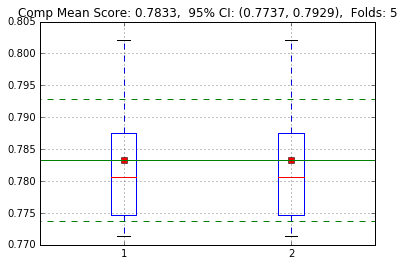

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0           0.087899  0.051213  122.864554        3.0          0.463737
Score: 0.7871
Time: 89.97 seconds
Score: 0.8021
Time: 118.49 seconds
Score: 0.7746
Time: 71.60 seconds
Score: 0.7812
Time: 69.81 seconds
Score: 0.7706
Time: 74.21 seconds
Score: 0.7871
Score: 0.8021
Score: 0.7746
Score: 0.7812
Score: 0.7706
Score: 0.7871
Score: 0.8021
Score: 0.7746
Score: 0.7812
Score: 0.7706


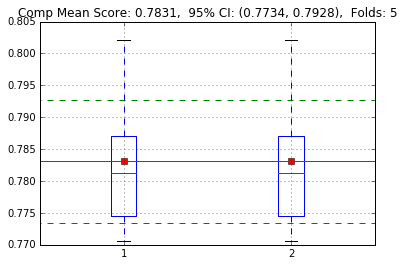

   colsample_bylevel    gamma     lambda  max_depth  min_child_weight
0           0.071358  0.20745  35.745627        2.0          1.586639
Score: 0.7877
Time: 129.87 seconds
Score: 0.8029
Time: 149.66 seconds
Score: 0.7730
Time: 81.58 seconds
Score: 0.7806
Time: 103.01 seconds
Score: 0.7698
Time: 78.14 seconds
Score: 0.7877
Score: 0.8029
Score: 0.7730
Score: 0.7806
Score: 0.7698
Score: 0.7877
Score: 0.8029
Score: 0.7730
Score: 0.7806
Score: 0.7698


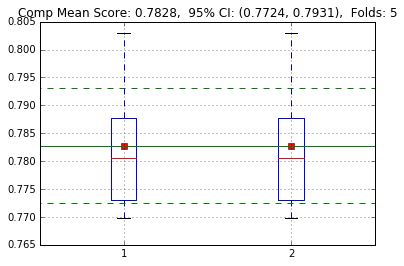

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.041898  0.031186  17.014364        3.0          0.214541
Score: 0.7869
Time: 71.66 seconds
Score: 0.8029
Time: 85.67 seconds
Score: 0.7731
Time: 52.50 seconds
Score: 0.7792
Time: 53.06 seconds
Score: 0.7701
Time: 43.86 seconds
Score: 0.7869
Score: 0.8029
Score: 0.7731
Score: 0.7792
Score: 0.7701
Score: 0.7869
Score: 0.8029
Score: 0.7731
Score: 0.7792
Score: 0.7701


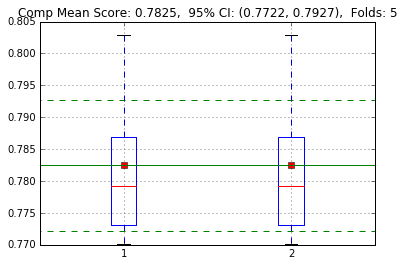

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0           0.094337  0.061709  399.313684        3.0         45.755995
Score: 0.7875
Time: 128.80 seconds
Score: 0.8006
Time: 147.85 seconds
Score: 0.7728
Time: 81.24 seconds
Score: 0.7792
Time: 105.38 seconds
Score: 0.7670
Time: 89.95 seconds
Score: 0.7875
Score: 0.8006
Score: 0.7728
Score: 0.7792
Score: 0.7670
Score: 0.7875
Score: 0.8006
Score: 0.7728
Score: 0.7792
Score: 0.7670


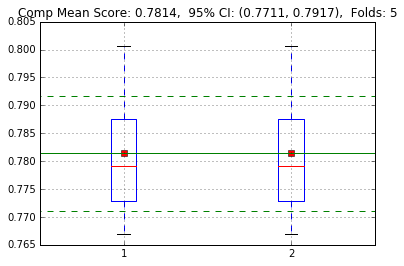

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.079391  0.284368  83.187169        2.0          0.537734
Score: 0.7880
Time: 130.80 seconds
Score: 0.8037
Time: 158.08 seconds
Score: 0.7744
Time: 95.33 seconds
Score: 0.7806
Time: 88.02 seconds
Score: 0.7685
Time: 81.81 seconds
Score: 0.7880
Score: 0.8037
Score: 0.7744
Score: 0.7806
Score: 0.7685
Score: 0.7880
Score: 0.8037
Score: 0.7744
Score: 0.7806
Score: 0.7685


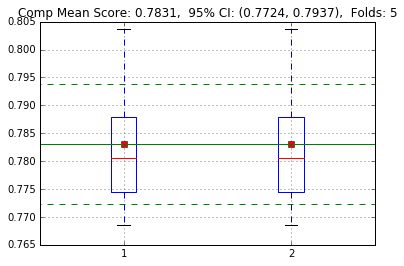

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.098315  0.094058  186.21266        3.0          2.901279
Score: 0.7888
Time: 105.25 seconds
Score: 0.8032
Time: 117.54 seconds
Score: 0.7759
Time: 88.19 seconds
Score: 0.7821
Time: 104.83 seconds
Score: 0.7690
Time: 83.60 seconds
Score: 0.7888
Score: 0.8032
Score: 0.7759
Score: 0.7821
Score: 0.7690
Score: 0.7888
Score: 0.8032
Score: 0.7759
Score: 0.7821
Score: 0.7690


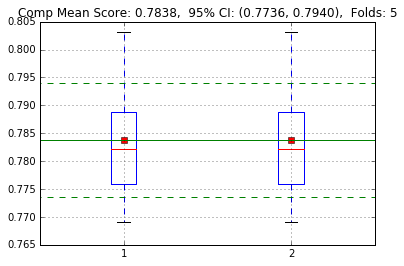

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0           0.096808  0.070813  272.806559        2.0         51.585159
Score: 0.7865
Time: 173.37 seconds
Score: 0.8022
Time: 198.34 seconds
Score: 0.7727
Time: 116.82 seconds
Score: 0.7803
Time: 136.30 seconds
Score: 0.7684
Time: 121.23 seconds
Score: 0.7865
Score: 0.8022
Score: 0.7727
Score: 0.7803
Score: 0.7684
Score: 0.7865
Score: 0.8022
Score: 0.7727
Score: 0.7803
Score: 0.7684


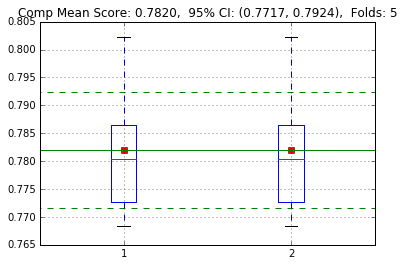

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0           0.097941  0.016033  159.961967        3.0         31.290382
Score: 0.7896
Time: 110.97 seconds
Score: 0.8044
Time: 136.29 seconds
Score: 0.7742
Time: 65.79 seconds
Score: 0.7805
Time: 83.05 seconds
Score: 0.7710
Time: 78.77 seconds
Score: 0.7896
Score: 0.8044
Score: 0.7742
Score: 0.7805
Score: 0.7710
Score: 0.7896
Score: 0.8044
Score: 0.7742
Score: 0.7805
Score: 0.7710


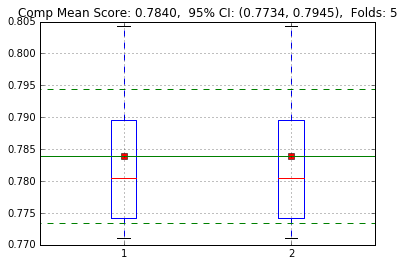

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0            0.13111  0.012193  347.392483        3.0         11.338068
Score: 0.7887
Time: 130.25 seconds
Score: 0.8042
Time: 185.11 seconds
Score: 0.7743
Time: 96.49 seconds
Score: 0.7810
Time: 136.51 seconds
Score: 0.7706
Time: 131.27 seconds
Score: 0.7887
Score: 0.8042
Score: 0.7743
Score: 0.7810
Score: 0.7706
Score: 0.7887
Score: 0.8042
Score: 0.7743
Score: 0.7810
Score: 0.7706


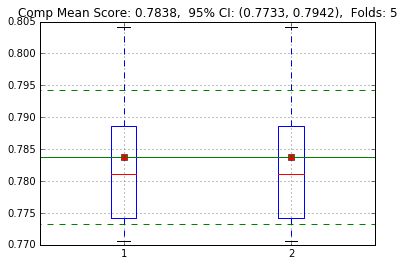

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.109278  0.002671  80.039129        3.0         34.416378
Score: 0.7883
Time: 91.15 seconds
Score: 0.8026
Time: 126.81 seconds
Score: 0.7747
Time: 73.69 seconds
Score: 0.7804
Time: 89.77 seconds
Score: 0.7707
Time: 72.84 seconds
Score: 0.7883
Score: 0.8026
Score: 0.7747
Score: 0.7804
Score: 0.7707
Score: 0.7883
Score: 0.8026
Score: 0.7747
Score: 0.7804
Score: 0.7707


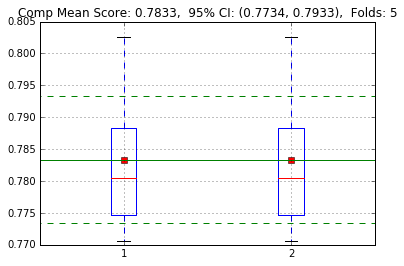

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0           0.097794  0.084481  216.673046        2.0          5.728526
Score: 0.7878
Time: 170.02 seconds
Score: 0.8026
Time: 198.97 seconds
Score: 0.7748
Time: 143.73 seconds
Score: 0.7808
Time: 121.87 seconds
Score: 0.7694
Time: 132.42 seconds
Score: 0.7878
Score: 0.8026
Score: 0.7748
Score: 0.7808
Score: 0.7694
Score: 0.7878
Score: 0.8026
Score: 0.7748
Score: 0.7808
Score: 0.7694


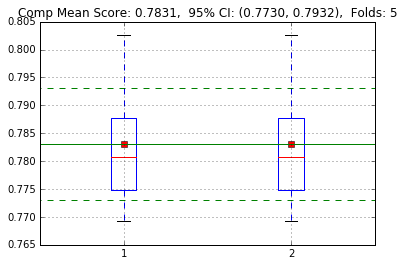

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.102159  0.003582  12.542904        3.0          3.005051
Score: 0.7867
Time: 73.27 seconds
Score: 0.8013
Time: 93.10 seconds
Score: 0.7743
Time: 61.55 seconds
Score: 0.7806
Time: 75.10 seconds
Score: 0.7719
Time: 52.85 seconds
Score: 0.7867
Score: 0.8013
Score: 0.7743
Score: 0.7806
Score: 0.7719
Score: 0.7867
Score: 0.8013
Score: 0.7743
Score: 0.7806
Score: 0.7719


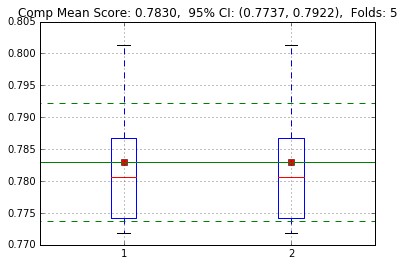

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0            0.14881  0.150535  97.386409        3.0          8.220372
Score: 0.7885
Time: 97.55 seconds
Score: 0.8027
Time: 138.12 seconds
Score: 0.7759
Time: 87.13 seconds
Score: 0.7819
Time: 91.39 seconds
Score: 0.7691
Time: 77.94 seconds
Score: 0.7885
Score: 0.8027
Score: 0.7759
Score: 0.7819
Score: 0.7691
Score: 0.7885
Score: 0.8027
Score: 0.7759
Score: 0.7819
Score: 0.7691


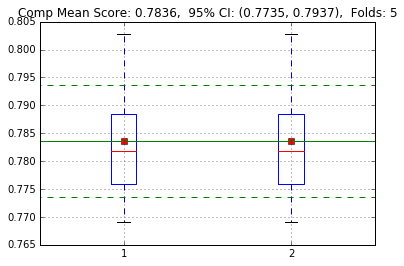

   colsample_bylevel     gamma    lambda  max_depth  min_child_weight
0           0.136821  0.155783  25.48591        2.0          2.925309
Score: 0.7859
Time: 95.37 seconds
Score: 0.8027
Time: 120.59 seconds
Score: 0.7730
Time: 90.64 seconds
Score: 0.7804
Time: 92.44 seconds
Score: 0.7704
Time: 78.11 seconds
Score: 0.7859
Score: 0.8027
Score: 0.7730
Score: 0.7804
Score: 0.7704
Score: 0.7859
Score: 0.8027
Score: 0.7730
Score: 0.7804
Score: 0.7704


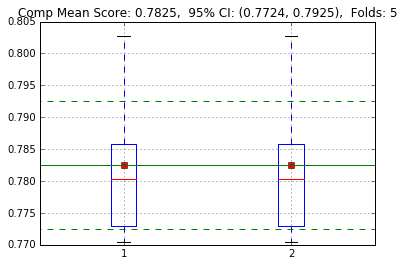

   colsample_bylevel     gamma    lambda  max_depth  min_child_weight
0           0.115023  0.013079  4.440365        3.0         13.077846
Score: 0.7869
Time: 70.60 seconds
Score: 0.8010
Time: 101.97 seconds
Score: 0.7734
Time: 53.50 seconds
Score: 0.7785
Time: 75.15 seconds
Score: 0.7708
Time: 52.55 seconds
Score: 0.7869
Score: 0.8010
Score: 0.7734
Score: 0.7785
Score: 0.7708
Score: 0.7869
Score: 0.8010
Score: 0.7734
Score: 0.7785
Score: 0.7708


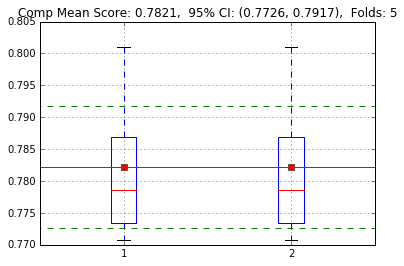

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0           0.107469  0.004267  392.485514        3.0          6.765868
Score: 0.7873
Time: 161.51 seconds
Score: 0.8042
Time: 161.31 seconds
Score: 0.7755
Time: 112.35 seconds
Score: 0.7828
Time: 108.22 seconds
Score: 0.7691
Time: 101.72 seconds
Score: 0.7873
Score: 0.8042
Score: 0.7755
Score: 0.7828
Score: 0.7691
Score: 0.7873
Score: 0.8042
Score: 0.7755
Score: 0.7828
Score: 0.7691


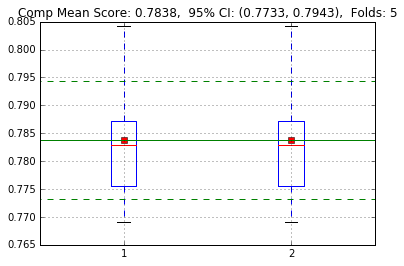

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0           0.142599  0.687548  138.877782        2.0         44.183643
Score: 0.7853
Time: 142.40 seconds
Score: 0.8029
Time: 179.19 seconds
Score: 0.7732
Time: 112.71 seconds
Score: 0.7798
Time: 144.33 seconds
Score: 0.7678
Time: 115.84 seconds
Score: 0.7853
Score: 0.8029
Score: 0.7732
Score: 0.7798
Score: 0.7678
Score: 0.7853
Score: 0.8029
Score: 0.7732
Score: 0.7798
Score: 0.7678


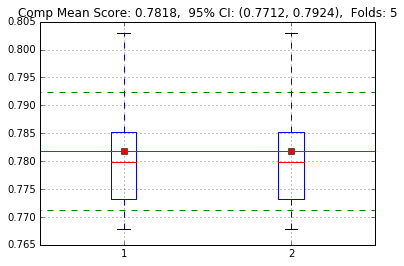

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0           0.081449  0.107031  289.316956        3.0         27.426817
Score: 0.7891
Time: 113.88 seconds
Score: 0.8023
Time: 124.89 seconds
Score: 0.7760
Time: 102.14 seconds
Score: 0.7812
Time: 114.00 seconds
Score: 0.7691
Time: 63.97 seconds
Score: 0.7891
Score: 0.8023
Score: 0.7760
Score: 0.7812
Score: 0.7691
Score: 0.7891
Score: 0.8023
Score: 0.7760
Score: 0.7812
Score: 0.7691


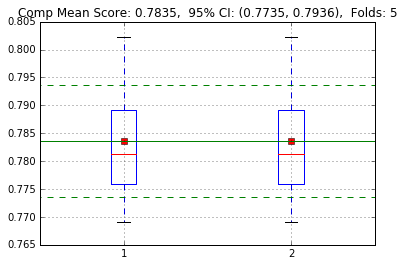

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0            0.10075  0.020036  60.099716        3.0          3.745635
Score: 0.7870
Time: 91.18 seconds
Score: 0.8031
Time: 115.82 seconds
Score: 0.7748
Time: 55.02 seconds
Score: 0.7804
Time: 96.86 seconds
Score: 0.7716
Time: 71.19 seconds
Score: 0.7870
Score: 0.8031
Score: 0.7748
Score: 0.7804
Score: 0.7716
Score: 0.7870
Score: 0.8031
Score: 0.7748
Score: 0.7804
Score: 0.7716


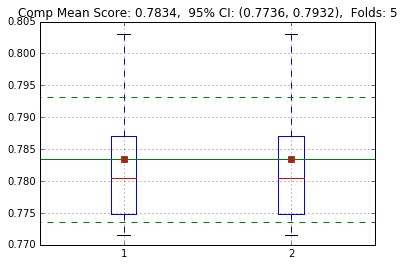

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.090886  0.034705  32.874282        4.0          0.254445
Score: 0.7863
Time: 54.24 seconds
Score: 0.7999
Time: 64.47 seconds
Score: 0.7743
Time: 55.22 seconds
Score: 0.7800
Time: 58.81 seconds
Score: 0.7688
Time: 41.13 seconds
Score: 0.7863
Score: 0.7999
Score: 0.7743
Score: 0.7800
Score: 0.7688
Score: 0.7863
Score: 0.7999
Score: 0.7743
Score: 0.7800
Score: 0.7688


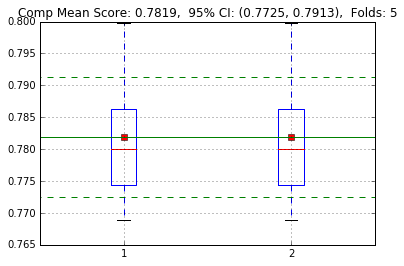

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0           0.049405  0.017442  180.804296        2.0          0.725351
Score: 0.7874
Time: 147.08 seconds
Score: 0.8024
Time: 146.75 seconds
Score: 0.7746
Time: 127.58 seconds
Score: 0.7798
Time: 101.57 seconds
Score: 0.7680
Time: 90.62 seconds
Score: 0.7874
Score: 0.8024
Score: 0.7746
Score: 0.7798
Score: 0.7680
Score: 0.7874
Score: 0.8024
Score: 0.7746
Score: 0.7798
Score: 0.7680


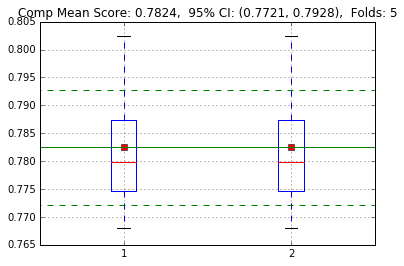

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.120984  0.005762  96.764749        4.0          1.652537
Score: 0.7875
Time: 88.93 seconds
Score: 0.8005
Time: 108.13 seconds
Score: 0.7760
Time: 66.92 seconds
Score: 0.7815
Time: 93.44 seconds
Score: 0.7690
Time: 62.73 seconds
Score: 0.7875
Score: 0.8005
Score: 0.7760
Score: 0.7815
Score: 0.7690
Score: 0.7875
Score: 0.8005
Score: 0.7760
Score: 0.7815
Score: 0.7690


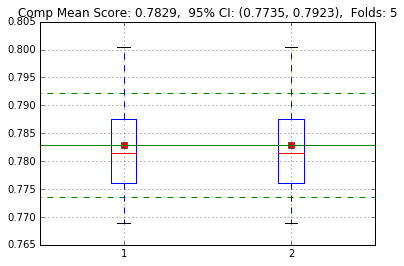

   colsample_bylevel     gamma     lambda  max_depth  min_child_weight
0           0.065965  0.009333  20.274372        3.0          14.24295
Score: 0.7886
Time: 117.02 seconds
Score: 0.8007
Time: 124.48 seconds
Score: 0.7734
Time: 60.29 seconds
Score: 0.7808
Time: 84.91 seconds
Score: 0.7677
Time: 64.96 seconds
Score: 0.7886
Score: 0.8007
Score: 0.7734
Score: 0.7808
Score: 0.7677
Score: 0.7886
Score: 0.8007
Score: 0.7734
Score: 0.7808
Score: 0.7677


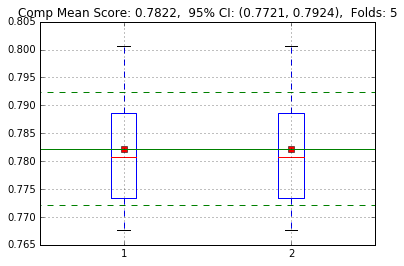

   colsample_bylevel     gamma    lambda  max_depth  min_child_weight
0           0.110601  1.707333  10.47743        4.0          5.262636
Score: 0.7832
Time: 78.70 seconds
Score: 0.8012
Time: 71.93 seconds
Score: 0.7741
Time: 78.46 seconds
Score: 0.7779
Time: 86.63 seconds
Score: 0.7689
Time: 59.79 seconds
Score: 0.7832
Score: 0.8012
Score: 0.7741
Score: 0.7779
Score: 0.7689
Score: 0.7832
Score: 0.8012
Score: 0.7741
Score: 0.7779
Score: 0.7689


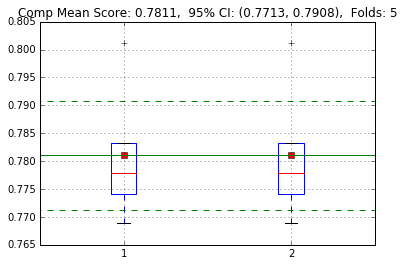

   colsample_bylevel     gamma   lambda  max_depth  min_child_weight
0           0.129327  0.049662  6.09799        2.0          8.611968
Score: 0.7869
Time: 107.90 seconds
Score: 0.8006
Time: 127.94 seconds
Score: 0.7725
Time: 109.16 seconds
Score: 0.7809
Time: 134.55 seconds
Score: 0.7690
Time: 78.83 seconds
Score: 0.7869
Score: 0.8006
Score: 0.7725
Score: 0.7809
Score: 0.7690
Score: 0.7869
Score: 0.8006
Score: 0.7725
Score: 0.7809
Score: 0.7690


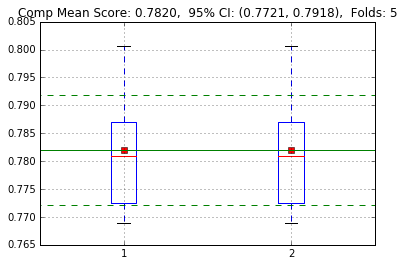

,min_child_weight,max_depth,lambda,gamma,colsample_bylevel,loss
32,31.290382,3.0,159.961967,0.016033,0.097941,-0.783951
30,2.901279,3.0,186.212660,0.094058,0.098315,-0.783803
40,6.765868,3.0,392.485514,0.004267,0.107469,-0.783784
33,11.338068,3.0,347.392483,0.012193,0.131110,-0.783757
14,25.730014,4.0,152.850175,0.025001,0.072342,-0.783651
37,8.220372,3.0,97.386409,0.150535,0.148810,-0.783614
42,27.426817,3.0,289.316956,0.107031,0.081449,-0.783538
43,3.745635,3.0,60.099716,0.020036,0.100750,-0.783379
34,34.416378,3.0,80.039129,0.002671,0.109278,-0.783345
24,0.517258,3.0,45.546531,0.292144,0.090157,-0.783275


In [71]:
parda = HpOpt(space, ParModelScore).sort_values(["loss"])
parda.to_csv("{}/{}_par_xgb.csv".format(path, title))
paropt = parda.iloc[0, :-1].to_dict()
parda

## Model Training
Cross model and prediction results from optimized model variables and hyper-parameters

Score: 0.7752
Time: 7.33 seconds
Score: 0.7814
Time: 7.48 seconds
Score: 0.7846
Time: 7.03 seconds
Score: 0.7950
Time: 8.34 seconds
Score: 0.7688
Time: 6.70 seconds
Score: 0.7751
Time: 6.27 seconds
Score: 0.7727
Time: 7.01 seconds
Score: 0.7658
Time: 6.73 seconds
Score: 0.7592
Time: 6.90 seconds
Score: 0.7727
Time: 6.70 seconds
Score: 0.7752
Score: 0.7814
Score: 0.7846
Score: 0.7950
Score: 0.7688
Score: 0.7751
Score: 0.7727
Score: 0.7658
Score: 0.7592
Score: 0.7727
Score: 0.7752
Score: 0.7814
Score: 0.7846
Score: 0.7950
Score: 0.7688
Score: 0.7751
Score: 0.7727
Score: 0.7658
Score: 0.7592
Score: 0.7727


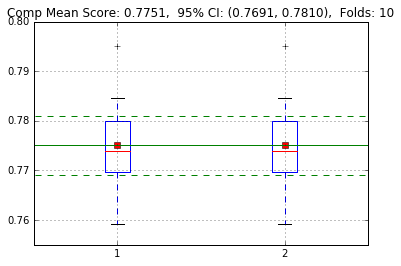

In [119]:
modellgrL = CrossTrain(x, y, irtL, Classifier, modeltype = lm.LogisticRegression,
                      parmodel = {"penalty": "l2", "C": 0.003, "class_weight": 'balanced', "solver": "sag"})
yt2plgrL = CrossValid(x, y, irtL, modellgrL)
CrossScoreAnalysis(y, [yt2plgrL], irtL)
yvplgrL = CrossPredict(xv, modellgrL)
(pd.DataFrame({'score':ModelMPredict([yvplgrL])}, index = irv).reset_index().rename_axis({"index": "Idx"}, axis = 1)
 .set_index("Idx").to_csv("{}/{}_op_lgr.csv".format(path, title)))

In [120]:
wcollgr = WeightCI(WeightModel, modellgrL)
wcollgr.to_csv("{}/{}_w_lgr.csv".format(path, title))

Score: 0.7897
Time: 467.33 seconds
Score: 0.7970
Time: 458.78 seconds
Score: 0.7984
Time: 359.29 seconds
Score: 0.8153
Time: 485.70 seconds
Score: 0.7739
Time: 278.61 seconds
Score: 0.7850
Time: 278.80 seconds
Score: 0.7855
Time: 385.56 seconds
Score: 0.7799
Time: 334.77 seconds
Score: 0.7682
Time: 271.12 seconds
Score: 0.7763
Time: 274.72 seconds
Score: 0.7897
Score: 0.7970
Score: 0.7984
Score: 0.8153
Score: 0.7739
Score: 0.7850
Score: 0.7855
Score: 0.7799
Score: 0.7682
Score: 0.7763
Score: 0.7897
Score: 0.7970
Score: 0.7984
Score: 0.8153
Score: 0.7739
Score: 0.7850
Score: 0.7855
Score: 0.7799
Score: 0.7682
Score: 0.7763


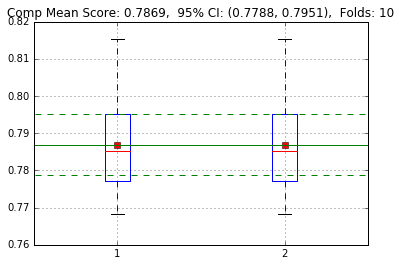

In [121]:
modelxgbL = CrossTrain(x, y, irtL, XGBoost, parmodel = {'colsample_bylevel': 0.07, 'eta': 0.02,
                                                        'max_depth': 3, 'lambda': 50, 'min_child_weight': 1.5, 'gamma': 0.2})
yt2pxgbL = CrossValid(x, y, irtL, modelxgbL)
CrossScoreAnalysis(y, [yt2pxgbL], irtL)
yvpxgbL = CrossPredict(xv, modelxgbL)
(pd.DataFrame({'score':ModelMPredict([yvpxgbL])}, index = irv).reset_index().rename_axis({"index": "Idx"}, axis = 1)
    .set_index("Idx").to_csv("{}/{}_op_xgb.csv".format(path, title)))

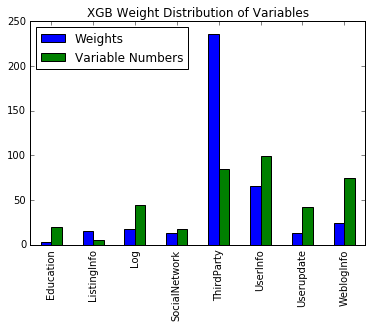

In [122]:
def RowS_summary(da, rows, f = ["sum", "count"]):
    grp = da.loc[rows.index].groupby(rows, axis = 0)
    daop = pd.concat(map(lambda x: getattr(grp, x)(), f), keys = f, axis = 1)
    return(daop)
wcolxgb = WeightCI(WeightModel, modelxgbL)
wcolxgb.to_csv("{}/{}_w_xgb.csv".format(path, title))
RowS_summary(wcolxgb.iloc[:,0], Col_group(wcolxgb.index), ["sum", "count"]).rename(
    columns = {"sum": "Weights", "count": "Variable Numbers"}).plot(kind = "bar", title = "XGB Weight Distribution of Variables")

In [123]:
pd.concat([wcollgr, wcolxgb], axis = 1, keys = ["LR", "XGB"]).to_csv("{}/{}_wcol.csv".format(path, title))

In [132]:
modeldnnL = CrossTrain(x, y, irtL, DNN, parmodel = {"nhidlayer": 1, "rdrop": 0.5, "nhidnode": 600, "outnode": 300, 'optimizer': "rmsprop", 
                                                    "maxnorm": 4, "batch_size": 64, "earlystop": 5})
yt2pdnnL = CrossValid(x, y, irtL, modeldnnL)
CrossScoreAnalysis(y, [yt2pdnnL], irtL)
yvpdnnL = CrossPredict(xv, modeldnnL)
(pd.DataFrame({'score':ModelMPredict([yvpdnnL])}, index = irv).reset_index().rename_axis({"index": "Idx"}, axis = 1)
 .set_index("Idx").to_csv("{}/{}_op_dnn.csv".format(path, title)))

Train on 71999 samples, validate on 8000 samples
Epoch 1/100
71999/71999 [==============================] - 26s - loss: 0.3021 - val_loss: 0.2414
Epoch 2/100
71999/71999 [==============================] - 27s - loss: 0.2421 - val_loss: 0.2357
Epoch 3/100
71999/71999 [==============================] - 27s - loss: 0.2363 - val_loss: 0.2361
Epoch 4/100
71999/71999 [==============================] - 27s - loss: 0.2316 - val_loss: 0.2403
Epoch 5/100
71999/71999 [==============================] - 29s - loss: 0.2294 - val_loss: 0.2372
Epoch 6/100
71999/71999 [==============================] - 28s - loss: 0.2281 - val_loss: 0.2350
Epoch 7/100
71999/71999 [==============================] - 31s - loss: 0.2258 - val_loss: 0.2356
Epoch 8/100
71999/71999 [==============================] - 31s - loss: 0.2244 - val_loss: 0.2370
Epoch 9/100
71999/71999 [==============================] - 32s - loss: 0.2229 - val_loss: 0.2366
Epoch 10/100
71999/71999 [==============================] - 32s - loss: 0.2223

KeyboardInterrupt: 

## Composite Models and Prediction
Combine different types of models and get optimized weights for the composite prediction.

Score: 0.7897
Score: 0.7752
Score: 0.7970
Score: 0.7814
Score: 0.7984
Score: 0.7846
Score: 0.8153
Score: 0.7950
Score: 0.7739
Score: 0.7688
Score: 0.7850
Score: 0.7751
Score: 0.7855
Score: 0.7727
Score: 0.7799
Score: 0.7658
Score: 0.7682
Score: 0.7592
Score: 0.7763
Score: 0.7727
Score: 0.7913
Score: 0.7985
Score: 0.7989
Score: 0.8147
Score: 0.7770
Score: 0.7862
Score: 0.7861
Score: 0.7803
Score: 0.7702
Score: 0.7785


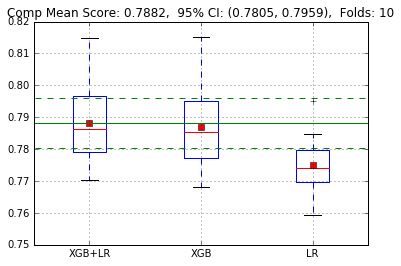

In [133]:
score, score2, w = CrossScoreAnalysis(y, [yt2pxgbL, yt2plgrL], irtL, [0.9, 0.1], ["XGB+LR", "XGB", "LR"])

Score: 0.7897
Score: 0.7706
Score: 0.7752
Score: 0.7970
Score: 0.7738
Score: 0.7814
Score: 0.7984
Score: 0.7709
Score: 0.7846
Score: 0.8153
Score: 0.7876
Score: 0.7950
Score: 0.7739
Score: 0.7693
Score: 0.7688
Score: 0.7850
Score: 0.7712
Score: 0.7751
Score: 0.7855
Score: 0.7742
Score: 0.7727
Score: 0.7799
Score: 0.7645
Score: 0.7658
Score: 0.7682
Score: 0.7578
Score: 0.7592
Score: 0.7763
Score: 0.7675
Score: 0.7727
Score: 0.7921
Score: 0.7983
Score: 0.7988
Score: 0.8155
Score: 0.7785
Score: 0.7874
Score: 0.7879
Score: 0.7815
Score: 0.7715
Score: 0.7801


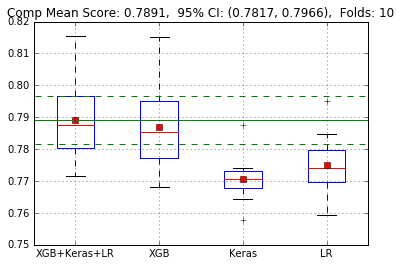

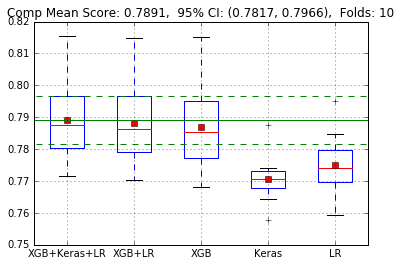

In [134]:
score, score1, w = CrossScoreAnalysis(y, [yt2pxgbL, yt2pdnnL, yt2plgrL], irtL, [0.75, 0.20, 0.05], ["XGB+Keras+LR", "XGB", "Keras", "LR"])
ScorePlot(np.vstack([score1, score2, score.T]).T, ["XGB+Keras+LR", "XGB+LR", "XGB", "Keras", "LR"])

In [135]:
def ModelWOpt(y, yt2pM, irtL, seed = 0):
    iw = ["w_{}".format(2+i) for i in range(len(yt2pM)-1)]
    space = dict(zip(*[iw, [hp.uniform(iw[i], 0, 1/len(yt2pM)) for i in range(len(yt2pM)-1)]]))
    def Obj(w):
        wtmp = [1-np.sum(list(w.values()))]+list(w.values())
        return({
            'loss': -np.mean(CrossScore(y, yt2pM, irtL, wtmp)),
            'status': STATUS_OK
            })
    np.random.seed(seed)
    trials = Trials()
    fmin(Obj,
        space=space,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials)
    op = pd.concat([pd.DataFrame({"loss": trials.losses()}),
                    pd.DataFrame([sum(list(trials.trials[i]["misc"]["vals"].values()), []) for i in range(len(trials))],
                                 columns = list(trials.trials[0]["misc"]["vals"].keys()))], axis = 1)
    return(op)

In [113]:
wopt = ModelWOpt(y, [yt2pxgbL, yt2pdnnL, yt2plgrL], irtL).sort_values(by = "loss")
wopt = wopt.assign(w_1 = 1 - wopt.iloc[:,1:].sum(axis = 1)).sort_index(axis = 1)
wcomp = wopt.iloc[0,1:].tolist()
wopt

Score: 0.7892
Score: 0.7943
Score: 0.7962
Score: 0.8129
Score: 0.7758
Score: 0.7852
Score: 0.7852
Score: 0.7796
Score: 0.7696
Score: 0.7781
Score: 0.7909
Score: 0.7967
Score: 0.7978
Score: 0.8164
Score: 0.7764
Score: 0.7871
Score: 0.7877
Score: 0.7821
Score: 0.7715
Score: 0.7790
Score: 0.7884
Score: 0.7929
Score: 0.7941
Score: 0.8105
Score: 0.7763
Score: 0.7843
Score: 0.7851
Score: 0.7782
Score: 0.7693
Score: 0.7786
Score: 0.7865
Score: 0.7905
Score: 0.7924
Score: 0.8078
Score: 0.7749
Score: 0.7825
Score: 0.7831
Score: 0.7763
Score: 0.7674
Score: 0.7777
Score: 0.7900
Score: 0.7963
Score: 0.7976
Score: 0.8154
Score: 0.7752
Score: 0.7861
Score: 0.7861
Score: 0.7812
Score: 0.7704
Score: 0.7778
Score: 0.7900
Score: 0.7958
Score: 0.7973
Score: 0.8148
Score: 0.7759
Score: 0.7861
Score: 0.7862
Score: 0.7809
Score: 0.7705
Score: 0.7783
Score: 0.7907
Score: 0.7966
Score: 0.7979
Score: 0.8161
Score: 0.7761
Score: 0.7868
Score: 0.7872
Score: 0.7820
Score: 0.7712
Score: 0.7787
Score: 0.7909
Score:

,loss,w_1,w_2,w_3
58,-0.788618,0.728990,0.232908,0.038102
85,-0.788616,0.784017,0.165579,0.050403
66,-0.788586,0.784012,0.156592,0.059396
22,-0.788581,0.736678,0.201663,0.061658
48,-0.788578,0.795136,0.148876,0.055988
84,-0.788565,0.815762,0.147840,0.036398
87,-0.788563,0.812743,0.136994,0.050263
29,-0.788559,0.761273,0.172879,0.065848
1,-0.788555,0.786718,0.148842,0.064440
95,-0.788547,0.795134,0.141978,0.062888


In [136]:
opcomp = pd.DataFrame({'score':ModelMPredict([yvpxgbL, yvpdnnL, yvplgrL], [0.75, 0.20, 0.05])}, index = irv).reset_index().rename_axis({"index": "Idx"}, axis = 1).set_index("Idx")
opcomp.to_csv("{}/{}_op.csv".format(path, title))